In [1]:
#import necessary libraries
import pandas as pd
import pytz
from glob import glob
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import inspect
import time
import numpy as np
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
#input the data
files = glob('tmp*.csv')
files

['tmp37y3hzwj.csv',
 'tmpb6n1t_qb.csv',
 'tmp9uci4wac.csv',
 'tmp_424i9_2.csv',
 'tmpunyiwxpl.csv',
 'tmpzj47dpf4.csv']

In [3]:
#exploring the data
frames = [pd.read_csv(file) for file in files]
df = pd.concat(frames)
df.head()

,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,50;DHT22;3573;-1.289;36.825;2023-01-01T00:00:0...
1,50;DHT22;3573;-1.289;36.825;2023-01-01T00:00:0...
2,71;pms5003;35;-1.297;36.743;2023-01-01T00:00:1...
3,71;pms5003;35;-1.297;36.743;2023-01-01T00:00:1...
4,71;pms5003;35;-1.297;36.743;2023-01-01T00:00:1...


In [3]:
# Build your `wrangle` function
def wrangle(filepath):
    
    df=pd.read_csv(filepath)
    
    #split the data
    df[["sensor_id", "sensor_type",
    'location','lat','lon','timestamp','value_type',
    'value']] = df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"].str.split(";", expand=True)
    
    #drop columns
    df.drop(columns="sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value", inplace=True)
    
    #convert the type
    df["sensor_id"]=df["sensor_id"].astype(float)
    df['location']=df['location'].astype(float)
    df['lat']=df['lat'].astype(float)
    df['lon']=df['lon'].astype(float)
    df['value']=df['value'].astype(float)
    df['timestamp']= pd.to_datetime(df['timestamp'],format='%Y-%m-%d %H:%M:%S')
    
    #set index as timestamp
    df = df.set_index('timestamp')
    
    #convert the time in Nairobi time
    df.index=df.index.tz_convert('Africa/Nairobi')
    
    #drop columns
    drop_cols=['sensor_id', 'sensor_type','location','lat', 'lon']
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [4]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
df.head()

,value_type,value
timestamp,,
2023-01-01 03:00:00.587438+03:00,humidity,99.9
2023-01-01 03:00:00.587438+03:00,temperature,17.1
2023-01-01 03:00:19.768006+03:00,P2,25.0
2023-01-01 03:00:19.768006+03:00,P1,35.4
2023-01-01 03:00:19.768006+03:00,P0,14.6


In [5]:
df = df[df["value_type"].str.contains("temperature") == False]
df = df[df["value_type"].str.contains("humidity") == False]
df = df[df["value_type"].str.contains("P0") == False]
df = df[df["value_type"].str.contains("P2") == False]
# Remove outliers
df = df[df["value"] < 500]
df= df['value'].resample('1H').mean().fillna(method='ffill').to_frame()

In [6]:
df['P1']=df['value']
df.drop(columns=['value'], inplace=True)

In [7]:
#data head overview
df.head()

,P1
timestamp,
2023-01-01 03:00:00+03:00,28.286747
2023-01-01 04:00:00+03:00,27.386752
2023-01-01 05:00:00+03:00,44.341346
2023-01-01 06:00:00+03:00,47.108961
2023-01-01 07:00:00+03:00,51.902984


In [8]:
df.shape

(4112, 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4112 entries, 2023-01-01 03:00:00+03:00 to 2023-06-21 10:00:00+03:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P1      4112 non-null   float64
dtypes: float64(1)
memory usage: 64.2 KB


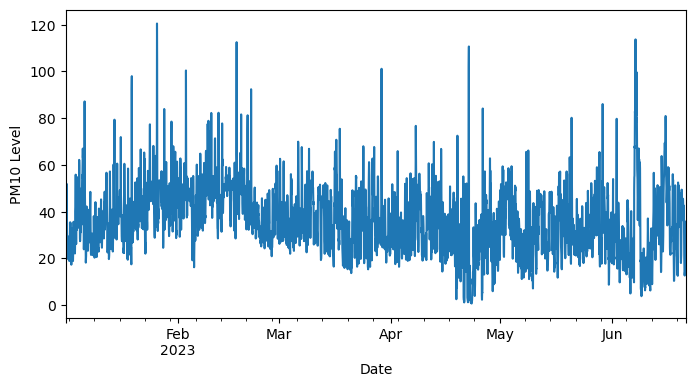

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

df['P1'].plot(xlabel='Date', ylabel='PM10 Level', ax=ax);

In [11]:
from statsmodels.tsa.stattools import adfuller

# ADF test for stationary
def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('PM10 ADF Statistic: ', test_results[0])
    print('PM10 P-Value: ', test_results[1])
    print('PM10 Critical Values:')
    for threshold, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (threshold, adf_stat))


print(adf_test(df['P1']))

PM10 ADF Statistic:  -6.728559490472014
PM10 P-Value:  3.3409929611713515e-09
PM10 Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
None


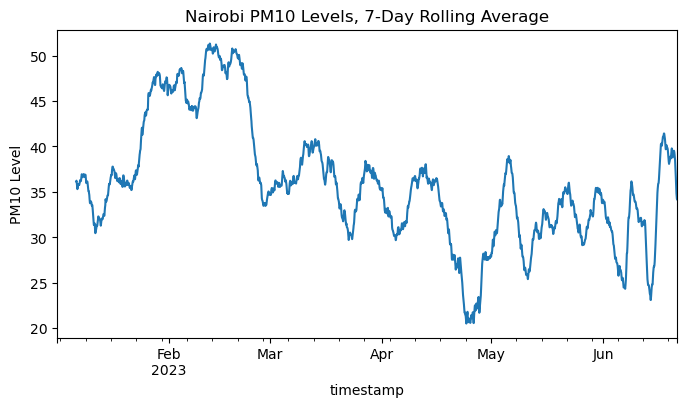

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
df['P1'].rolling(128).mean().plot(ax=ax, ylabel='PM10 Level', 
                           title="Nairobi PM10 Levels, 7-Day Rolling Average");

In [13]:
df.to_csv('file1.csv')

In [19]:
from scipy.stats import boxcox

# Make the target stationary
df['P1_boxcox'], lam = boxcox(df['P1'])
df["P1_stationary"] = df["P1_boxcox"].diff()
df.dropna(inplace=True)



In [13]:
from scipy.stats import boxcox
df["P1_stationary"] = df["P1"].diff()
df.dropna(inplace=True)

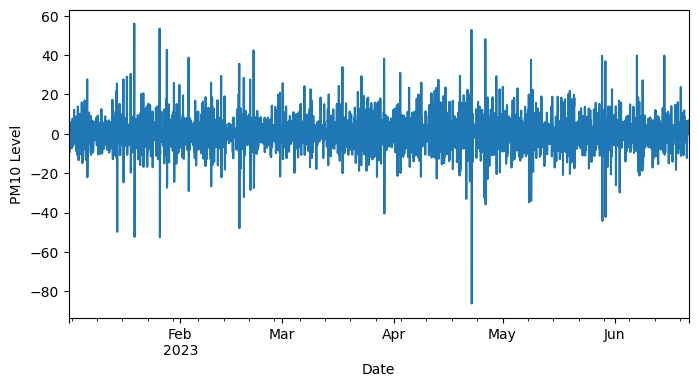

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

df['P1_stationary'].plot(xlabel='Date', ylabel='PM10 Level', ax=ax);

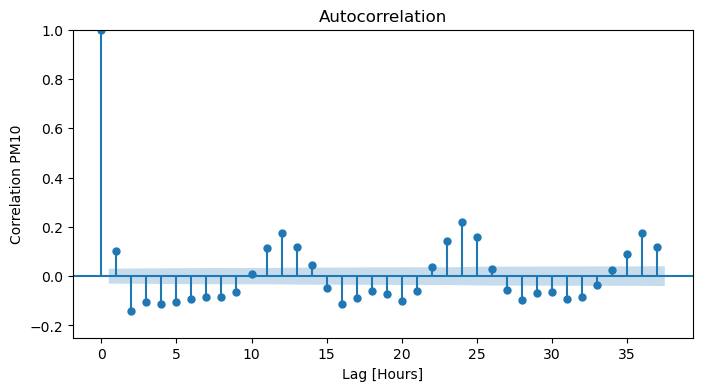

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
plot_acf(df['P1_stationary'],ax=ax)
ax.set_ylim(-0.25,1)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation PM10");

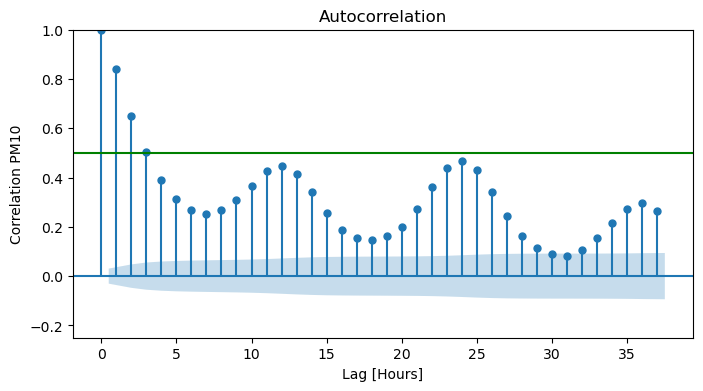

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
plot_acf(df['P1'],ax=ax)
ax.set_ylim(-0.25,1)
plt.axhline(y=0.5, color='green')
plt.axhline(y=-0.5, color='green')
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation PM10");

In [21]:
cutoff_test = int(len(df['P1'])*0.80)
y_train = df['P1'].iloc[:cutoff_test].dropna()
y_test = df['P1'].iloc[cutoff_test:].dropna()
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (3288,)
y_test shape: (823,)


In [18]:
cutoff_test = int(len(df['P1_stationary'])*0.80)
train = df['P1_stationary'].iloc[:cutoff_test].dropna()
test = df['P1_stationary'].iloc[cutoff_test:].dropna()
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (3288,)
test shape: (823,)


In [22]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)


print("Mean PM 10 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean PM 10 Reading: 36.5921664501423
Baseline MAE: 10.690988090676278


In [19]:
y_train_mean = train.mean()
y_pred_baseline = [y_train_mean]*len(train)
mae_baseline = mean_absolute_error(train, y_pred_baseline)


print("Mean PM 10  stationary Reading:", y_train_mean)
print("Baseline MAE: stationary", mae_baseline)

Mean PM 10  stationary Reading: -0.003957538933574458
Baseline MAE: stationary 5.3316647012363445


In [61]:
lag = range(1, 38)
mean_abs = []
for p in lag:
    # Train model and fit
    model = AutoReg(y_train,lags=p).fit()
    # Generate training predictions
    y_pred = model.predict().dropna()
    # Calculate training mean absolute errors
    mae = mean_absolute_error(y_train.iloc[p:],y_pred)
    # Append mae to mean_abs list
    mean_abs.append(mae)
print((mean_abs.index(min(mean_abs))+1),min(mean_abs) )

35 1.5844144029663745


In [83]:
mean_abs.index(min(mean_abs))

36

In [28]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history,lags=2).fit()
    next_pred=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_pred)
    history=history.append(y_test[next_pred.index])

In [24]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))
test_mae = r2_score(y_test,y_pred_wfv)
print("Test r2 ( walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 5.19
Test r2 ( walk forward validation): 0.79


In [27]:
df_pred_test=pd.DataFrame(
   {'True Values': y_test, 'Predictions':y_pred_wfv}

)
fig = px.line(df_pred_test, labels={"value": "PM10 Levels"})
fig.show()

In [31]:
mape=np.mean(np.abs(y_pred_wfv-y_test)/np.abs(y_test))

In [32]:
mape

0.20294608622675633

In [43]:
# Import packages
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Split train and test
train = df.iloc[:-int(len(df) * 0.2)]
test = df.iloc[-int(len(df) * 0.2):]

# Build AR model
selector = ar_select_order(train['P1_stationary'], 38)
model = AutoReg(train['P1_stationary'], lags=selector.ar_lags).fit()

In [44]:
train.columns

Index(['P1', 'P1_boxcox', 'P1_stationary'], dtype='object')

In [67]:
test['P1_stationary']

timestamp
2023-05-18 05:00:00+03:00    2.488096
2023-05-18 06:00:00+03:00    6.171602
2023-05-18 07:00:00+03:00    1.644395
2023-05-18 08:00:00+03:00   -2.775677
2023-05-18 09:00:00+03:00   -1.189376
                               ...   
2023-06-21 06:00:00+03:00    2.291243
2023-06-21 07:00:00+03:00   -0.001283
2023-06-21 08:00:00+03:00    1.320510
2023-06-21 09:00:00+03:00    2.403884
2023-06-21 10:00:00+03:00    0.543143
Freq: H, Name: P1_stationary, Length: 822, dtype: float64

In [65]:
boxcox_forecasts

[11.203636085303366,
 14.075915870872095,
 14.725417691222592,
 15.226155102267454,
 15.959643075884156,
 15.531324306782746,
 14.861861773631887,
 14.54001753777537,
 14.437447226746075,
 14.65455703362452,
 15.224938734591571,
 15.60604256224728,
 15.808351365604134,
 16.642194626296188,
 16.675423978161263,
 16.03893670569868,
 15.100489711541949,
 14.242735484695277,
 13.51958407998879,
 12.757916892106676,
 11.951651077187208,
 11.597888228655975,
 11.66546040831613,
 12.196201750305246,
 13.170778579362793,
 14.103336073487585,
 14.584876666790219,
 14.816894446545238,
 14.816151590159816,
 14.481726477980823,
 14.068267709278,
 13.788719190099563,
 13.653353282067323,
 13.675779467769345,
 13.884507222704308,
 14.27700346118121,
 14.790791983276755,
 15.278806303016895,
 15.474601785339168,
 15.35249288774248,
 14.993326854278395,
 14.51641025983121,
 14.014322545267703,
 13.524340971585941,
 13.122389223727133,
 12.942286750000243,
 13.02793990228474,
 13.350840741179901,
 13.8

/var/folders/jc/vnml05q56xnchvrrng072ywc0000gn/T/ipykernel_11117/2179733016.py:8: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



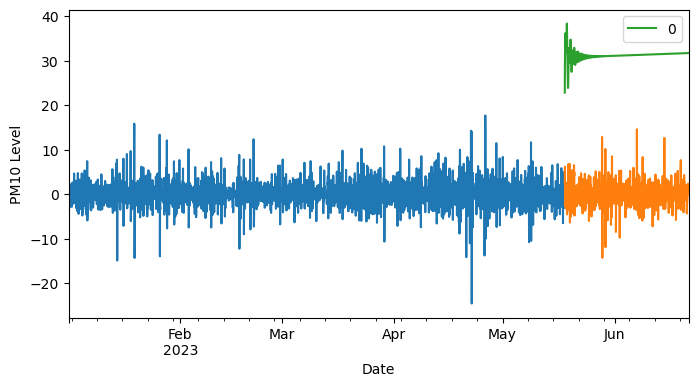

In [55]:
def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig, ax = plt.subplots(figsize=(8, 4))
    train['P1_stationary'].plot(xlabel='Date', ylabel='PM10 Level', ax=ax);
    test['P1_stationary'].plot(xlabel='Date', ylabel='PM10 Level', ax=ax);
    forecast.plot(xlabel='Date', ylabel='PM10 Level', ax=ax);
    return fig.show()



plot_forecasts(forecasts, 'Autoregression')

In [56]:
df_pred_test=pd.DataFrame(
   {'y_test': y_test, 'y_pred':y_pred_wfv}

)
df_pred_test.head()

,y_test,y_pred
2023-05-18 04:00:00+03:00,0.337725,-0.040199
2023-05-18 05:00:00+03:00,2.488096,0.039148
2023-05-18 06:00:00+03:00,6.171602,0.296664
2023-05-18 07:00:00+03:00,1.644395,0.742339
2023-05-18 08:00:00+03:00,-2.775677,0.199481


In [57]:
forecast.head()

,0
timestamp,
2023-05-18 05:00:00+03:00,22.855788
2023-05-18 06:00:00+03:00,30.695090
2023-05-18 07:00:00+03:00,32.563010
2023-05-18 08:00:00+03:00,34.025912
2023-05-18 09:00:00+03:00,36.203901


In [58]:
test['P1_stationary']

timestamp
2023-05-18 05:00:00+03:00    2.488096
2023-05-18 06:00:00+03:00    6.171602
2023-05-18 07:00:00+03:00    1.644395
2023-05-18 08:00:00+03:00   -2.775677
2023-05-18 09:00:00+03:00   -1.189376
                               ...   
2023-06-21 06:00:00+03:00    2.291243
2023-06-21 07:00:00+03:00   -0.001283
2023-06-21 08:00:00+03:00    1.320510
2023-06-21 09:00:00+03:00    2.403884
2023-06-21 10:00:00+03:00    0.543143
Freq: H, Name: P1_stationary, Length: 822, dtype: float64

In [ ]:
df_pred_test=pd.DataFrame(
   {'y_test': y_test, 'y_pred':y_pred_wfv}

)
fig = px.line(df_pred_test, labels={"value": "PM10 Levels"})
fig.show()

In [51]:
 forecast['timestamp']=test['P1'].index

In [53]:
forecast['timestamp']= pd.to_datetime(forecast['timestamp'],format='%Y-%m-%d %H:%M:%S')
    
#set index as timestamp
forecast= forecast.set_index('timestamp')

In [54]:
forecast

,0
timestamp,
2023-05-18 05:00:00+03:00,22.855788
2023-05-18 06:00:00+03:00,30.695090
2023-05-18 07:00:00+03:00,32.563010
2023-05-18 08:00:00+03:00,34.025912
2023-05-18 09:00:00+03:00,36.203901
...,...
2023-06-21 06:00:00+03:00,31.725136
2023-06-21 07:00:00+03:00,31.726390
2023-06-21 08:00:00+03:00,31.727645


In [89]:
lag=range(1, 37)
q_params=range(0,3)
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in lag:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train,y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (1, 0, 0) in 5.12 seconds.
Trained ARIMA (1, 0, 1) in 0.55 seconds.
Trained ARIMA (1, 0, 2) in 0.83 seconds.
Trained ARIMA (2, 0, 0) in 0.84 seconds.
Trained ARIMA (2, 0, 1) in 0.79 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (2, 0, 2) in 4.35 seconds.
Trained ARIMA (3, 0, 0) in 1.86 seconds.
Trained ARIMA (3, 0, 1) in 2.61 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (3, 0, 2) in 3.95 seconds.
Trained ARIMA (4, 0, 0) in 0.98 seconds.
Trained ARIMA (4, 0, 1) in 2.77 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (4, 0, 2) in 3.78 seconds.
Trained ARIMA (5, 0, 0) in 1.04 seconds.
Trained ARIMA (5, 0, 1) in 5.9 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (5, 0, 2) in 8.23 seconds.
Trained ARIMA (6, 0, 0) in 1.34 seconds.
Trained ARIMA (6, 0, 1) in 6.36 seconds.
Trained ARIMA (6, 0, 2) in 6.28 seconds.
Trained ARIMA (7, 0, 0) in 1.85 seconds.
Trained ARIMA (7, 0, 1) in 8.34 seconds.
Trained ARIMA (7, 0, 2) in 10.52 seconds.
Trained ARIMA (8, 0, 0) in 2.63 seconds.
Trained ARIMA (8, 0, 1) in 8.66 seconds.
Trained ARIMA (8, 0, 2) in 7.17 seconds.
Trained ARIMA (9, 0, 0) in 3.11 seconds.
Trained ARIMA (9, 0, 1) in 8.65 seconds.
Trained ARIMA (9, 0, 2) in 9.48 seconds.
Trained ARIMA (10, 0, 0) in 4.1 seconds.
Trained ARIMA (10, 0, 1) in 10.69 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (10, 0, 2) in 17.0 seconds.
Trained ARIMA (11, 0, 0) in 3.78 seconds.
Trained ARIMA (11, 0, 1) in 10.54 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (11, 0, 2) in 24.71 seconds.
Trained ARIMA (12, 0, 0) in 4.23 seconds.
Trained ARIMA (12, 0, 1) in 9.81 seconds.
Trained ARIMA (12, 0, 2) in 13.64 seconds.
Trained ARIMA (13, 0, 0) in 6.2 seconds.
Trained ARIMA (13, 0, 1) in 18.56 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (13, 0, 2) in 26.49 seconds.
Trained ARIMA (14, 0, 0) in 9.43 seconds.
Trained ARIMA (14, 0, 1) in 20.82 seconds.
Trained ARIMA (14, 0, 2) in 16.29 seconds.
Trained ARIMA (15, 0, 0) in 7.74 seconds.
Trained ARIMA (15, 0, 1) in 25.4 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (15, 0, 2) in 33.67 seconds.
Trained ARIMA (16, 0, 0) in 6.06 seconds.
Trained ARIMA (16, 0, 1) in 16.34 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (16, 0, 2) in 35.37 seconds.
Trained ARIMA (17, 0, 0) in 10.55 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (17, 0, 1) in 40.1 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (17, 0, 2) in 39.83 seconds.
Trained ARIMA (18, 0, 0) in 14.86 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (18, 0, 1) in 42.25 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (18, 0, 2) in 45.22 seconds.
Trained ARIMA (19, 0, 0) in 12.45 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (19, 0, 1) in 55.81 seconds.
Trained ARIMA (19, 0, 2) in 53.28 seconds.
Trained ARIMA (20, 0, 0) in 13.68 seconds.
Trained ARIMA (20, 0, 1) in 54.95 seconds.
Trained ARIMA (20, 0, 2) in 59.71 seconds.
Trained ARIMA (21, 0, 0) in 23.44 seconds.
Trained ARIMA (21, 0, 1) in 87.32 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (21, 0, 2) in 118.98 seconds.
Trained ARIMA (22, 0, 0) in 33.08 seconds.
Trained ARIMA (22, 0, 1) in 76.23 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (22, 0, 2) in 119.98 seconds.
Trained ARIMA (23, 0, 0) in 45.14 seconds.
Trained ARIMA (23, 0, 1) in 82.51 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (23, 0, 2) in 122.55 seconds.
Trained ARIMA (24, 0, 0) in 42.96 seconds.
Trained ARIMA (24, 0, 1) in 80.48 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (24, 0, 2) in 121.95 seconds.
Trained ARIMA (25, 0, 0) in 45.0 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (25, 0, 1) in 148.3 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (25, 0, 2) in 155.4 seconds.
Trained ARIMA (26, 0, 0) in 54.95 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (26, 0, 1) in 164.31 seconds.
Trained ARIMA (26, 0, 2) in 123.22 seconds.
Trained ARIMA (27, 0, 0) in 61.85 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (27, 0, 1) in 199.12 seconds.
Trained ARIMA (27, 0, 2) in 158.83 seconds.
Trained ARIMA (28, 0, 0) in 67.31 seconds.
Trained ARIMA (28, 0, 1) in 100.61 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (28, 0, 2) in 244.49 seconds.
Trained ARIMA (29, 0, 0) in 72.92 seconds.
Trained ARIMA (29, 0, 1) in 109.57 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (29, 0, 2) in 239.76 seconds.
Trained ARIMA (30, 0, 0) in 75.34 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (30, 0, 1) in 235.76 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (30, 0, 2) in 252.44 seconds.
Trained ARIMA (31, 0, 0) in 103.46 seconds.
Trained ARIMA (31, 0, 1) in 136.59 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (31, 0, 2) in 330.54 seconds.
Trained ARIMA (32, 0, 0) in 118.16 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (32, 0, 1) in 286.91 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (32, 0, 2) in 257.31 seconds.
Trained ARIMA (33, 0, 0) in 108.93 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (33, 0, 1) in 325.15 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (33, 0, 2) in 346.67 seconds.
Trained ARIMA (34, 0, 0) in 196.28 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (34, 0, 1) in 534.35 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (34, 0, 2) in 619.82 seconds.
Trained ARIMA (35, 0, 0) in 192.19 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (35, 0, 1) in 818.08 seconds.
Trained ARIMA (35, 0, 2) in 798.61 seconds.
Trained ARIMA (36, 0, 0) in 280.83 seconds.
Trained ARIMA (36, 0, 1) in 658.68 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (36, 0, 2) in 762.29 seconds.

{1: [5.320827744606481, 5.184619772757842, 5.186534098189762], 2: [5.177682809227908, 5.186944355991966, 5.186321519574184], 3: [5.183288107896819, 5.183251633739137, 5.18341300978432], 4: [5.1845048424245626, 5.182954587234609, 5.1832905820038135], 5: [5.184341594298962, 5.059979333210929, 5.116765226775027], 6: [5.179662112871172, 5.053134405687426, 5.0633006798126], 7: [5.153076737538053, 5.0318048759612335, 5.05509488323304], 8: [5.110320379730791, 5.019501505006862, 5.030289583871885], 9: [5.036333467615311, 4.987675121837242, 5.019808118743143], 10: [4.972038127127979, 4.968596856399611, 4.868861215835841], 11: [4.962031778083656, 4.964117499329402, 4.946240224319868], 12: [4.9659494838465985, 4.965053502370516, 4.962662722148768], 13: [4.955071991370057, 4.94747137670809, 4.944443148946029], 14: [4.945313423464831, 4.94440323466952, 4.948707314533331], 15: [4.950674971254996, 4.950488397943889, 4.944995089163979], 16: [4.9507363576566

In [14]:
m={1: [5.320827744606481, 5.184619772757842, 5.186534098189762], 2: [5.177682809227908, 5.186944355991966, 5.186321519574184], 3: [5.183288107896819, 5.183251633739137, 5.18341300978432], 4: [5.1845048424245626, 5.182954587234609, 5.1832905820038135], 5: [5.184341594298962, 5.059979333210929, 5.116765226775027], 6: [5.179662112871172, 5.053134405687426, 5.0633006798126], 7: [5.153076737538053, 5.0318048759612335, 5.05509488323304], 8: [5.110320379730791, 5.019501505006862, 5.030289583871885], 9: [5.036333467615311, 4.987675121837242, 5.019808118743143], 10: [4.972038127127979, 4.968596856399611, 4.868861215835841], 11: [4.962031778083656, 4.964117499329402, 4.946240224319868], 12: [4.9659494838465985, 4.965053502370516, 4.962662722148768], 13: [4.955071991370057, 4.94747137670809, 4.944443148946029], 14: [4.945313423464831, 4.94440323466952, 4.948707314533331], 15: [4.950674971254996, 4.950488397943889, 4.944995089163979], 16: [4.950736357656608, 4.950996591759518, 4.9476257908236825], 17: [4.954524099920148, 4.912351401620321, 4.91310871623734], 18: [4.950842935180345, 4.908848582220519, 4.912590974643475], 19: [4.946749737382172, 4.890602916113008, 4.907756292768603], 20: [4.929960715816463, 4.877543579821028, 4.896683696600228], 21: [4.891834548439773, 4.853357413132472, 4.816787057759376], 22: [4.848328987290316, 4.833483174277653, 4.792562819515764], 23: [4.815153622584365, 4.816821932603717, 4.790928696532352], 24: [4.819135551543537, 4.816689224894648, 4.793659318853136], 25: [4.797873558249536, 4.790537478024887, 4.793025554236004], 26: [4.791053613704441, 4.790138400775293, 4.790824439707783], 27: [4.788342948904792, 4.788420344940251, 4.789667840962349], 28: [4.788857554164011, 4.788819378179815, 4.787725064581469], 29: [4.787923029998185, 4.787368143517576, 4.786337678487859], 30: [4.787337829060056, 4.787672413813133, 4.787501716465495], 31: [4.7886219484386485, 4.788264177812898, 4.7882129320445355], 32: [4.787417869232313, 4.791288899563821, 4.788380973607482], 33: [4.789267366741377, 4.78759627863745, 4.78845134923832], 34: [4.786383594598828, 4.7851922708327, 4.785971813893158], 35: [4.785941258338077, 
4.784661820920303, 4.784660621579853], 
   36: [4.781472312506715, 4.781479456903547, 4.775335152443032]}

In [15]:
mae_df = pd.DataFrame(m)
mae_df.round(4)

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
0,5.3208,5.1777,5.1833,5.1845,5.1843,5.1797,5.1531,5.1103,5.0363,4.9720,...,4.7883,4.7889,4.7879,4.7873,4.7886,4.7874,4.7893,4.7864,4.7859,4.7815
1,5.1846,5.1869,5.1833,5.1830,5.0600,5.0531,5.0318,5.0195,4.9877,4.9686,...,4.7884,4.7888,4.7874,4.7877,4.7883,4.7913,4.7876,4.7852,4.7847,4.7815
2,5.1865,5.1863,5.1834,5.1833,5.1168,5.0633,5.0551,5.0303,5.0198,4.8689,...,4.7897,4.7877,4.7863,4.7875,4.7882,4.7884,4.7885,4.7860,4.7847,4.7753


In [16]:
mae_df.min(axis=1)

0    4.781472
1    4.781479
2    4.775335
dtype: float64

In [ ]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model =ARIMA(history,order=[36,0,2]).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [ ]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))
test_mae = r2_score(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

In [ ]:
df_pred_test=pd.DataFrame(
   {'y_test': y_test, 'y_pred':y_pred_wfv}

)
fig = px.line(df_pred_test, labels={"value": "PM10 Levels"})
fig.show()

In [40]:
#input the data
files = glob('file*.csv')
files

['file1.csv', 'file2.csv', 'file3.csv']

In [23]:
#exploring the data
frames = [pd.read_csv(file) for file in files]
df = pd.concat(frames, axis=1)
#df.drop(columns=['timestamp'], inplace=True)
df.head()

,timestamp,P1,timestamp,P2
0,2023-01-01 03:00:00+03:00,28.286747,2023-01-01 03:00:00+03:00,23.587349
1,2023-01-01 04:00:00+03:00,27.386752,2023-01-01 04:00:00+03:00,22.523567
2,2023-01-01 05:00:00+03:00,44.341346,2023-01-01 05:00:00+03:00,35.353654
3,2023-01-01 06:00:00+03:00,47.108961,2023-01-01 06:00:00+03:00,37.461234
4,2023-01-01 07:00:00+03:00,51.902984,2023-01-01 07:00:00+03:00,41.497801


In [41]:
df=pd.read_csv('file1.csv')

In [42]:
file2=pd.read_csv('file2.csv')

In [43]:
file3=pd.read_csv('file3.csv')

In [44]:
file3=file3.drop(columns=['timestamp'])

In [45]:
df=df.drop(columns=['timestamp'])

In [46]:
df = pd.concat([df,file2,file3], axis=1)

In [47]:
df.head()

,P1,timestamp,P2,P0
0,28.286747,2023-01-01 03:00:00+03:00,23.587349,20.497552
1,27.386752,2023-01-01 04:00:00+03:00,22.523567,20.377037
2,44.341346,2023-01-01 05:00:00+03:00,35.353654,30.225940
3,47.108961,2023-01-01 06:00:00+03:00,37.461234,31.458485
4,51.902984,2023-01-01 07:00:00+03:00,41.497801,32.905060


In [48]:
df['timestamp']= pd.to_datetime(df['timestamp'],format='%Y-%m-%d %H:%M:%S')
#set index as timestamp
df = df.set_index('timestamp')

In [49]:
df.head()

,P1,P2,P0
timestamp,,,
2023-01-01 03:00:00+03:00,28.286747,23.587349,20.497552
2023-01-01 04:00:00+03:00,27.386752,22.523567,20.377037
2023-01-01 05:00:00+03:00,44.341346,35.353654,30.225940
2023-01-01 06:00:00+03:00,47.108961,37.461234,31.458485
2023-01-01 07:00:00+03:00,51.902984,41.497801,32.905060


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4112 entries, 2023-01-01 03:00:00+03:00 to 2023-06-21 10:00:00+03:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P1      4112 non-null   float64
 1   P2      4112 non-null   float64
 2   P0      4112 non-null   float64
dtypes: float64(3)
memory usage: 128.5 KB


In [51]:
df= df[['P1', 'P2', 'P0']].resample('1H').mean().fillna(method='ffill')

In [58]:
df.corr()

,P1,P2,P0
P1,1.000000,0.993488,0.743793
P2,0.993488,1.000000,0.746914
P0,0.743793,0.746914,1.000000


In [55]:
import seaborn as sns

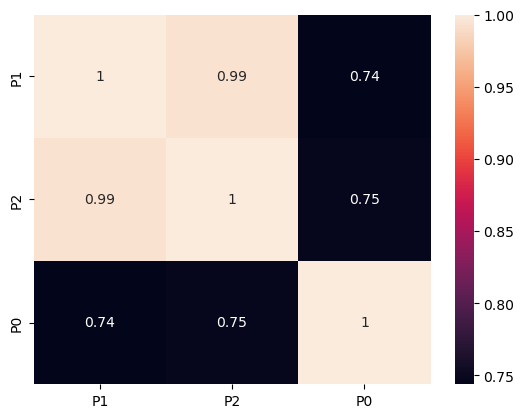

In [62]:
sns.heatmap(df.corr(),annot=True);
